# Import Libraries

In [2]:

import os
import numpy as np
import pandas as pd
import sybil_functions
import importlib
from datetime import datetime
from tqdm import tqdm
import requests
from time import sleep
import matplotlib.pyplot as plt
import random

importlib.reload(sybil_functions)

from sybil_functions import (
    read_from_multiple_csv,
    check_df,
    count_pairs,
    remove_contract_transactions,
    stretched_sigmoid,
    get_weight_df,
    plot_weight_dist,
    plot_weight_cumulative_dist,
    create_community,
    community_visualization,
    file_name_lst,
    random_rate,
    find_main_wallet,
    find_transfer_for_wallet,
    find_commu_for_wallet,
    uncommon_wallets,
    filter_community_lst,
    expand_community_lst,
    calculate_likelihoods,
)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}


In [3]:
os.getcwd()

'/Users/floras/Desktop/unique-user/moca-airdrop/model'

In [4]:
# set the path to the focal repository
os.chdir('/Users/floras/Desktop/unique-user')

# Import data

# Contract data

In [5]:
known_contract = read_from_multiple_csv(
    "contract-data",
    file_name_lst("contract-data", startswith="contract", endswith="moca_airdrop.csv"),
)
print(known_contract.shape)
known_contract.head()

(91, 4)


,address,contract/public account,sus,note
0,0x76dd65529dc6c073c1e0af2a5ecc78434bdbf7d9,y,NaN,NaN
1,0xe50ddf54c958a63ec1f2ab4fd48c899de7bfaa0b,NaN,y,"high-frequency in on polygon, mainly from 0x29..."
2,0x9008d19f58aabd9ed0d60971565aa8510560ab41,y,NaN,NaN
3,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,y,NaN,moca staking
4,0xdc066677b5ee2c577132b69ac13da6cf8a50c1c7,y,NaN,NaN


## White list

In [6]:
known_white = read_from_multiple_csv(
    "white-data",
    file_name_lst("white-data", startswith="white", endswith="moca_airdrop.csv"),
)
white_set = set(known_white["address"])
print(known_white.shape)
known_white.head()

(176, 2)


,address,Unnamed: 1
0,0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501,NaN
1,0xdd3d60296fd6c7e57fbe7d67472f708c178f4d29,NaN
2,0x31ea111ebe1963d409ae5731d8bb58975a4e187c,NaN
3,0xf8e9263f3e4485900634757ed34288d656cd3c99,NaN
4,0xda2495e2ee77469a471c946e334eed38d0179fd2,NaN


## Moca Airdrop Receiver Info

In [7]:
moca_airdrop_df = pd.read_excel('moca-airdrop/data/moca_airdrop_user_info.xlsx')
moca_airdrop_df.head()

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0


### Addresses with more than 1 Moca ID

In [8]:
addresses_with_more_than_one = moca_airdrop_df["address"].value_counts()
addresses_with_more_than_one = addresses_with_more_than_one[
    addresses_with_more_than_one > 1
]
addresses_with_more_than_one = addresses_with_more_than_one.index.tolist()

print(addresses_with_more_than_one)

['0x7646c2e54f972ea0def55b66b4f05416acd49db0', '0x916b0395e409bdcda99294fb5094d3492c0933cd', '0xfd1b9568fcdaee267c98f45070f27e17a82ffe43', '0x030e8df34cb8eca071b813472b4ac7822f39896d', '0x1611009da0dd85f772ef8fcff5de1a5cfdff8f97', '0x53078efd332cf24bc158804b7ac92e0cf6171327', '0x34e667710c5f5fbf366023fa1664bfc71e4bb2ae', '0x88720be48c436b763eb3978198a5261a856c9725', '0x65f8f6fc92d58aa586da5b678c994e1413d9e939']


### Wallet list and wallet set

In [9]:
wallet_lst = moca_airdrop_df["address"]
wallet_lst = wallet_lst.str.lower()
wallet_lst = [x for x in wallet_lst if x not in set(addresses_with_more_than_one)]

wallet_set = set(wallet_lst)
wallet_lst = list(wallet_set)
print(len(wallet_lst))

29156


## Native token transfer data

In [10]:
native_trans_path = 'moca-airdrop/data/raw-data'

In [11]:
native_trans_file_lst = file_name_lst(
    native_trans_path, startswith="native", endswith=".csv"
)
native_trans_df = read_from_multiple_csv(native_trans_path, native_trans_file_lst)
native_trans_df = native_trans_df[
    native_trans_df["from_address"].isin(wallet_set)
    | native_trans_df["to_address"].isin(wallet_set)
]
native_trans_df = native_trans_df[
    (native_trans_df["from_address"].isna() == False)
    & (native_trans_df["to_address"].isna() == False)
]
native_trans_df.columns = ["timestamp", "from_address", "to_address", "native_tx_count"]
native_trans_df.head()

,timestamp,from_address,to_address,native_tx_count
0,2024-06-01 00:00:00.000 UTC,0xbb14ed78c9fc563e5263bc3502fa86aec887194b,0xca3840c43962aa4857f9237463825071cb7da071,10
1,2024-06-01 00:00:00.000 UTC,0xf36f26f3d31f58772c99321fafed6729c3f47f5e,0xa137e8b1ff0339328572bad9c788c23586eaa63c,28
2,2024-06-01 00:00:00.000 UTC,0xda1bbc89a1deeed513363654324a0ebb17946ee0,0x6c5e87309ee7ff13628cc8c8dbb5fbbb4cb7ca5c,29
3,2024-06-01 00:00:00.000 UTC,0xf0cbace7452b530aa18ff0870e3475ec71ba362b,0x95a7f9cd4db3564146599267f7848fe20ad5c59e,1
4,2024-06-01 00:00:00.000 UTC,0xf327d13cd7bc9b3ea7485a97dfbbd0cc998635b8,0x6b1e3ddecc11583ed189b1db217873aa1c65a72e,1


## Moca coin transfer data

In [12]:
moca_trans_path = 'moca-airdrop/data/raw-data'

In [13]:
moca_trans_file_lst = file_name_lst(moca_trans_path, startswith= 'mocacoin', endswith='.csv')
moca_trans_df = read_from_multiple_csv(moca_trans_path, moca_trans_file_lst)
moca_trans_df = moca_trans_df[
    moca_trans_df['from_address'].isin(wallet_set) | moca_trans_df['to_address'].isin(wallet_set)
]
moca_trans_df.columns = ['from_address', 'to_address', 'moca_tx_count']
moca_trans_df

,from_address,to_address,moca_tx_count
0,0x6b22ca1ba7fc8d7f96cdb13ab68f082c27ed78d3,0x4c510f3b6e4190037c24fdb41fcb4c312a42c3e3,2
1,0x02c97159c1b3ca84b919ce26e8fc97150f410413,0x70b4463181ed9a4079d4917327af63cfdac3bc3f,1
2,0x8d25e246a03f9f20444f13576e8fdc6e7f188eca,0x8d25e246a03f9f20444f13576e8fdc6e7f188eca,1
3,0x1629d7c04d64336eb61426d602f530609cb57b75,0x1ea319d90011c17e8f144552f1f75d7a3f8916d6,1
4,0x50c49098c25d69136c0592154b4d5d4c0e1fa84b,0xff85a314a083c947238972aad732814a83c9a4af,1
...,...,...,...
7752,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,0x6b5bdd4dc61ff37d1ac5d5c35b100cd643c4b2da,1
7753,0xeca741697c604b0f7acf3112beb28f07567671bb,0xdaee8684102f80b7c39a7ea300a234bf42a01588,1
7754,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,0x20336a028b81251219ce5342959ed79826cac3f5,1
7755,0x9a98e6b60784634ae273f2fb84519c7f1885aed2,0x2c4be594c174690c22701333d0f96efe3fddc836,1


# Remove contract transactions

In [14]:
# wallet_to_test = list(set(trans_df["from_address"].unique()).union(set(trans_df["to_address"].unique())))
# wallet_to_test = uncommon_wallets(wallet_to_test, balance_df['wallet_address'])
# wallet_to_test = uncommon_wallets(wallet_to_test, known_contract['address'])

# print(len(wallet_to_test))

In [15]:
# # loop through all addresses
# new_found_contract_lst = []

# for i in tqdm(range(494, len(wallet_to_test))):
#     sleep(0.15)
#     address = list(wallet_to_test)[i]
#     # oklink api
#     url = f"https://www.oklink.com/api/v5/explorer/eth/api?module=contract&action=getabi&address={address}"
#     headers = {"Ok-Access-Key": "f0f1e2ec-7e9a-470d-aa0f-a436cc55c2e6"}
#     response = requests.request(method="GET", url=url, headers=headers)
#     response_json = response.json()

#     try:
#         if response_json["status"] == "1":
#             new_found_contract_lst.append(address)
#             print(f"Address: {address}")
#     except:
#         print(f"Error in getting info for: {address}")
#         print(response_json)
#         pass

In [16]:
# # add the new found contract to the end of contract_ape_holder.csv
# new_found_contract_df = pd.DataFrame(new_found_contract_lst, columns=["address"])
# new_found_contract_df.to_csv(
#     "edu/data/processed_data/contract_ape_holder.csv",
#     index=False,
#     mode="a",
#     header=False,
# )

In [17]:
# check size
print("native: ", native_trans_df.shape[0])
print("moca: ", moca_trans_df.shape[0])
print("")

# remove contract transactions
native_trans_df = remove_contract_transactions(
    native_trans_df, ["from_address", "to_address"], known_contract["address"]
)
moca_trans_df = remove_contract_transactions(
    moca_trans_df, ["from_address", "to_address"], known_contract["address"]
)
trans_df = pd.concat([native_trans_df, moca_trans_df], ignore_index=True)

# check size
print("native: ", native_trans_df.shape[0])
print("moca: ", moca_trans_df.shape[0])
print("total: ", trans_df.shape[0])

native:  180673
moca:  7744

native:  161297
moca:  3521
total:  164818


# Get transaction counts

## For native

In [18]:
native_trans_df_count = native_trans_df.copy()
native_trans_df_count["pair"] = native_trans_df_count.apply(
    lambda x: tuple(sorted([x["to_address"], x["from_address"]])), axis=1
)

# Sum the transaction counts for each wallet pair
native_trans_df_count = native_trans_df_count.groupby("pair")["native_tx_count"].sum()
native_trans_df_count = pd.DataFrame(native_trans_df_count)
native_trans_df_count = get_weight_df(native_trans_df_count)
native_trans_df_count = native_trans_df_count.sort_values(
    by="native_tx_count", ascending=False
)

# if no need to check
native_trans_df_count["if_wallet_a"] = native_trans_df_count["wallet_a"].isin(
    wallet_set.union(white_set)
)
native_trans_df_count["if_wallet_b"] = native_trans_df_count["wallet_b"].isin(
    wallet_set.union(white_set)
)

# native_trans_df_count = native_trans_df_count.sort_values(by='tx_count', ascending=False)
native_trans_df_count[
    ~native_trans_df_count["if_wallet_a"] | ~native_trans_df_count["if_wallet_b"]
].head(20)

,pair,native_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b
69156,"(0x7ac79c369a3585b19e068578d37916259e497616, 0...",113,0x7ac79c369a3585b19e068578d37916259e497616,0xaec37292d361417610977045d863500907762712,True,False
12668,"(0x1052a3af2476e5c39a05c07c75135af81ad8cae5, 0...",113,0x1052a3af2476e5c39a05c07c75135af81ad8cae5,0xcae756ac91bdafd828dae5ae6b6c83b8d509583e,False,True
64590,"(0x6fe0c938f6c5059597081a5738407f8610e72cd2, 0...",110,0x6fe0c938f6c5059597081a5738407f8610e72cd2,0xecbce6a0e79c5a3060879fed54dbee62b032250b,False,True
68315,"(0x78aba45e3cc94b7bbf163f34aebfb1d02a2f2308, 0...",110,0x78aba45e3cc94b7bbf163f34aebfb1d02a2f2308,0xb0b50a71b450643188c7bf56ebc2dbe1ee7a3037,True,False
44800,"(0x45c25565541575a8167495c6ca470310e38c805d, 0...",109,0x45c25565541575a8167495c6ca470310e38c805d,0xfcfefaadf519499bd661fce55918a244d334c500,True,False
88954,"(0xbe5072933fca2523ea9b060937c4b784405933dc, 0...",107,0xbe5072933fca2523ea9b060937c4b784405933dc,0xf9329d35fd7a87e2aa87a51acd4863dc50be0d4c,True,False
89147,"(0xbf66ed3c3fde88f2ca462b218755ea46258e543c, 0...",106,0xbf66ed3c3fde88f2ca462b218755ea46258e543c,0xf21dfbf90dab607635291120aa4577f3c0b04d0c,False,True
21723,"(0x1e8958b0771533c95407c40a45f913d945e0b7db, 0...",105,0x1e8958b0771533c95407c40a45f913d945e0b7db,0xa4446eb85b69fca6c2cb50b3eb235f5e299a4bde,False,True
25361,"(0x23ee9f950168b5b8938e09b2f07e08b9a7a70d79, 0...",105,0x23ee9f950168b5b8938e09b2f07e08b9a7a70d79,0xdf8dd5e0b4168f20a3488ad088ddb198fe602cb3,True,False
38751,"(0x3a06bce5a2d5bccba7b51018b4673dff9450bbe9, 0...",104,0x3a06bce5a2d5bccba7b51018b4673dff9450bbe9,0x602faee794e16604fbb17511b1ad179a728ce61b,False,True


## For MocaCoin

In [19]:
moca_trans_df_count = moca_trans_df.copy()
moca_trans_df_count['pair'] = moca_trans_df_count.apply(lambda x: tuple(sorted([x['to_address'], x['from_address']])), axis=1)

# Sum the transaction counts for each wallet pair
moca_trans_df_count = moca_trans_df_count.groupby('pair')['moca_tx_count'].sum()
moca_trans_df_count = pd.DataFrame(moca_trans_df_count)
moca_trans_df_count = get_weight_df(moca_trans_df_count)
moca_trans_df_count = moca_trans_df_count.sort_values(by='moca_tx_count', ascending=False)

# if no need to check
moca_trans_df_count['if_wallet_a'] = moca_trans_df_count["wallet_a"].isin(wallet_set.union(white_set))
moca_trans_df_count['if_wallet_b'] = moca_trans_df_count["wallet_b"].isin(wallet_set.union(white_set))

# pol_trans_df_count = pol_trans_df_count.sort_values(by='tx_count', ascending=False)
moca_trans_df_count[~moca_trans_df_count['if_wallet_a'] | ~moca_trans_df_count['if_wallet_b']].head(20)

,pair,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b
2106,"(0x6313d7948d3491096ffe00dea2d246d588b4d4fc, 0...",2,0x6313d7948d3491096ffe00dea2d246d588b4d4fc,0xd91efec7e42f80156d1d9f660a69847188950747,True,False
2146,"(0x65cccf23a99b0163dfe279d35b83194b83633807, 0...",2,0x65cccf23a99b0163dfe279d35b83194b83633807,0xcf50c596eafbfbf301f3a9983189ecdb78200301,True,False
332,"(0x0d10e1ab159c413e58a6717ae30bd2a6cbd2a4ba, 0...",2,0x0d10e1ab159c413e58a6717ae30bd2a6cbd2a4ba,0x4d24d86aa1c5f70bcb875241f6ea0c609f15707c,False,True
2835,"(0x97ef3f7720baee010e6714347fa13b478e2b1491, 0...",2,0x97ef3f7720baee010e6714347fa13b478e2b1491,0xe517f5274a21c74ae230d99010ad11992d0e836b,False,True
2412,"(0x78f7d94fde86903a51d248da04b6e606bd301511, 0...",2,0x78f7d94fde86903a51d248da04b6e606bd301511,0xa99c12251ed08b62447c5c03bab8ba95930e8f61,True,False
620,"(0x1a3a27e789b14b23ef86105b235695f1dce27fbc, 0...",2,0x1a3a27e789b14b23ef86105b235695f1dce27fbc,0xfba60ab7624b17e23627e6062b094ea203f5c91e,True,False
411,"(0x1111111254eeb25477b68fb85ed929f73a960582, 0...",2,0x1111111254eeb25477b68fb85ed929f73a960582,0xf1d0e6348d64d287288b5518911a816e3361cb1f,False,True
1188,"(0x31b699415119b47fda845889a4ed161bb33e3826, 0...",2,0x31b699415119b47fda845889a4ed161bb33e3826,0xeb5472754882c7f6662728daa655321f2d28f5ac,False,True
168,"(0x063dfb3f0abf2180655a3994e72fc062a66968b4, 0...",2,0x063dfb3f0abf2180655a3994e72fc062a66968b4,0x8b5b1519222035b9c967e5f674be2a05b7f53887,False,True
2485,"(0x7e46caf20338cedcf3fd61dafa7ad003d0d2ff75, 0...",2,0x7e46caf20338cedcf3fd61dafa7ad003d0d2ff75,0xf17cd420b438529c27eaff9e0ba10ef3ac2560ac,False,True


## Concate and get transaction count again

In [20]:
print(len(native_trans_df_count))
print(len(moca_trans_df_count))

trans_df_count = pd.concat(
    [
        native_trans_df_count[["pair", "native_tx_count"]],
        moca_trans_df_count[["pair", "moca_tx_count"]],
    ],
    ignore_index=True,
)
trans_df_count = trans_df_count.fillna(0)
check_df(trans_df_count)

95823
3514


(99337, 3)

pair                object
native_tx_count    float64
moca_tx_count      float64
dtype: object

,native_tx_count,moca_tx_count
count,99337.000000,99337.000000
mean,2.304076,0.038193
std,7.335441,0.215171
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,503.000000,8.000000


,pair,native_tx_count,moca_tx_count
0,"(0x8987c16b215bbff137a6a7198117457e16a7e59a, 0...",503.0,0.0
1,"(0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501, 0...",483.0,0.0
2,"(0x66f8195745387eaae67e19a6ef0257b40aeb8124, 0...",403.0,0.0
3,"(0x31ea111ebe1963d409ae5731d8bb58975a4e187c, 0...",370.0,0.0
4,"(0x9e718ecbf799498809b6d0183f46e2941344c9a9, 0...",323.0,0.0


In [21]:
trans_df_count = trans_df_count.groupby('pair').agg({
    'native_tx_count': 'sum',
    'moca_tx_count': 'sum'
})
trans_df_count = pd.DataFrame(trans_df_count)
trans_df_count = get_weight_df(trans_df_count)

# if in holder lst
trans_df_count['if_wallet_a'] = trans_df_count["wallet_a"].isin(wallet_set)
trans_df_count['if_wallet_b'] = trans_df_count["wallet_b"].isin(wallet_set)

trans_df_count = trans_df_count.sort_values(by='native_tx_count', ascending=False)

In [22]:
check_df(trans_df_count)

(98876, 7)

pair                object
native_tx_count    float64
moca_tx_count      float64
wallet_a            object
wallet_b            object
if_wallet_a           bool
if_wallet_b           bool
dtype: object

,native_tx_count,moca_tx_count
count,98876.000000,98876.000000
mean,2.314819,0.038371
std,7.350831,0.215656
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,503.000000,8.000000


,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b
77286,"(0x8987c16b215bbff137a6a7198117457e16a7e59a, 0...",503.0,0.0,0x8987c16b215bbff137a6a7198117457e16a7e59a,0x92df3900d9586611c3d60b22d28498958d0f89ad,True,True
90841,"(0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501, 0...",483.0,0.0,0xba1c4b823a1d9ba7c8e3012d6ec4f57d7ddfe501,0xcbffd9f33015af12383a0f210b4f37383386bbe9,False,True
62925,"(0x66f8195745387eaae67e19a6ef0257b40aeb8124, 0...",403.0,0.0,0x66f8195745387eaae67e19a6ef0257b40aeb8124,0xdd3d60296fd6c7e57fbe7d67472f708c178f4d29,True,False
34860,"(0x31ea111ebe1963d409ae5731d8bb58975a4e187c, 0...",370.0,0.0,0x31ea111ebe1963d409ae5731d8bb58975a4e187c,0x463c507e8b2ddc6aea0e45a736b3bf8b210bb36d,False,True
83878,"(0x9e718ecbf799498809b6d0183f46e2941344c9a9, 0...",323.0,0.0,0x9e718ecbf799498809b6d0183f46e2941344c9a9,0xd93f89eb91974e5ba75d2aed0d625741065bf537,True,True


### keep only wallet pairs with transactions in both native and moca

In [23]:
### keep only wallet pairs with transactions in both native and moca
trans_df_count = trans_df_count[
    trans_df_count["if_wallet_a"] & trans_df_count["if_wallet_b"]
]

# Transaction count -> Weight

In [24]:
# set sigmoid parameters
stretch = 1

In [25]:
weight_df = trans_df_count.copy()

# Revise the if_wallet_a and if_wallet_b columns
weight_df["if_wallet_a"] = weight_df["wallet_a"].isin(wallet_set)
weight_df["if_wallet_b"] = weight_df["wallet_b"].isin(wallet_set)

# Calculate the internal weight
weight_df["moca_weight"] = weight_df.apply(
    lambda x: (stretched_sigmoid(x["moca_tx_count"], stretch) - 0.5) * 5, axis=1
)

# Calculate the total weight
weight_df["native_weight"] = weight_df.apply(
    lambda x: stretched_sigmoid(x["native_tx_count"], stretch) - 0.5,
    axis=1,
)

weight_df["weight"] = weight_df["moca_weight"] + weight_df["native_weight"]

# Sort based on weight
weight_df = weight_df.sort_values(by="weight", ascending=False)

In [26]:
check_df(weight_df)

(13380, 10)

pair                object
native_tx_count    float64
moca_tx_count      float64
wallet_a            object
wallet_b            object
if_wallet_a           bool
if_wallet_b           bool
moca_weight        float64
native_weight      float64
weight             float64
dtype: object

,native_tx_count,moca_tx_count,moca_weight,native_weight,weight
count,13380.000000,13380.000000,13380.000000,13380.000000,13380.000000
mean,2.649851,0.047459,0.054152,0.301418,0.355570
std,9.025301,0.221578,0.246487,0.121077,0.219601
min,0.000000,0.000000,0.000000,0.000000,0.231059
25%,1.000000,0.000000,0.000000,0.231059,0.231059
50%,1.000000,0.000000,0.000000,0.231059,0.231059
75%,2.000000,0.000000,0.000000,0.380797,0.452574
max,503.000000,5.000000,2.466536,0.500000,2.959843


,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
23966,"(0x211cea4e6e15457f2e92c611714e7b11b0738055, 0...",5.0,5.0,0x211cea4e6e15457f2e92c611714e7b11b0738055,0xea5f4f4440ff3cc417d09b43d6f8da1f14175846,True,True,2.466536,0.493307,2.959843
23732,"(0x20bb8555eecac05c0cdcb0307fcce03000d57b46, 0...",1.0,5.0,0x20bb8555eecac05c0cdcb0307fcce03000d57b46,0xba943f9a82e378eac5c33bbc92263e82ee64f50b,True,True,2.466536,0.231059,2.697594
11071,"(0x0d754d85b3cec2ed304cdb2542c6a040104dc9b3, 0...",16.0,2.0,0x0d754d85b3cec2ed304cdb2542c6a040104dc9b3,0x331e1ba82b52b88c5ac9f920be978b8f5c171d36,True,True,1.903985,0.500000,2.403985
87442,"(0xab0dee2006c7d84330b95cfa7c38da4307dfd74e, 0...",12.0,2.0,0xab0dee2006c7d84330b95cfa7c38da4307dfd74e,0xdac4c0c7c0fe9890b08ac59bddb3bb96ec098992,True,True,1.903985,0.499994,2.403979
60053,"(0x60573af6a5daeb77697fc48ecf8804a1fc0b5307, 0...",2.0,2.0,0x60573af6a5daeb77697fc48ecf8804a1fc0b5307,0x9aed6f124f882bb607f31dcb9b0701fc3ea50bbf,True,True,1.903985,0.380797,2.284782


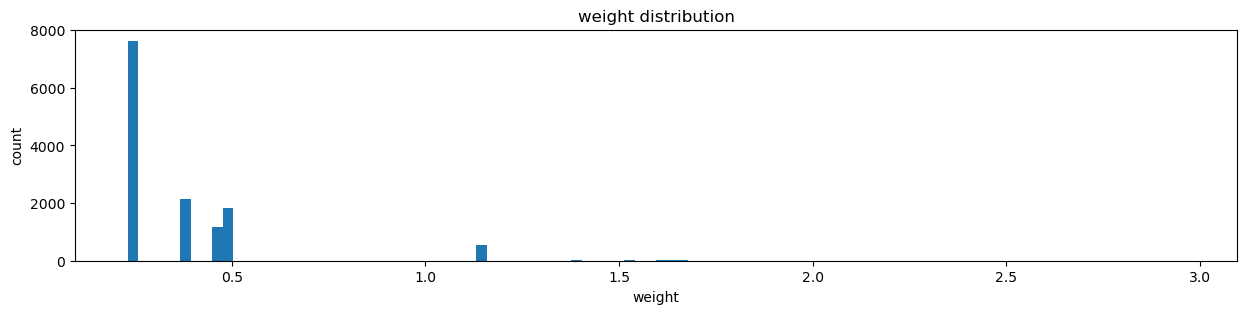

In [27]:
plot_weight_dist(weight_df)

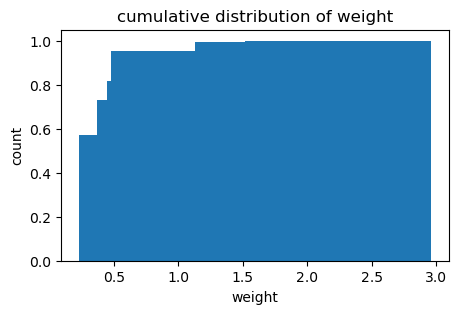

In [28]:
plot_weight_cumulative_dist(weight_df)

# Weight -> Community

In [29]:
community_lst_lou, G_lou = create_community(weight_df, "louvain", resolution=1)

# community_lst_s = create_community(weight_df, 'surprise')
# community_lst_lei = create_community(weight_df, 'leiden')

Method: louvain
Number of unique wallets: 10822
Number of edges: 13380
Number of communities detected: 3608
-
Average community size: 2.9994456762749446
Max community size: 264
Min community size: 1



In [30]:
# get the wallet likelihood of louvain
wallet_likelihood_lou = calculate_likelihoods(community_lst_lou, G_lou)

In [31]:
# get the wallet likelihood df
wallet_likelihood_df = pd.DataFrame(wallet_likelihood_lou).T.reset_index(drop=False)
wallet_likelihood_df["if_airdrop"] = wallet_likelihood_df["index"].isin(wallet_set)
wallet_likelihood_df['if_white'] = wallet_likelihood_df['index'].isin(white_set)

In [32]:
# row_lst = range(10)
row_lst = [2]
community_lst_visualization_1 = community_lst_lou

# get the wallet info of the current community
wallet_info_df_1 = wallet_likelihood_df[
    wallet_likelihood_df["community"] == row_lst[0]
]

for row in row_lst:
    community = community_lst_visualization_1[row]
    print("Size of community:", len(community))
    # print(find_main_wallet(community, weight_df))

    commu_visual_df_1 = weight_df.loc[
        weight_df["wallet_a"].isin(community) & weight_df["wallet_b"].isin(community)
    ]

    print("Average weight:", commu_visual_df_1["weight"].mean())

Size of community: 166
Average weight: 0.23105857863000517


In [33]:
# community_visualization(commu_visual_df_1)

In [34]:
commu_visual_df_1

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
21815,"(0x1d820b0fc24aa71d439140b99520bb826d13f0c3, 0...",1.0,0.0,0x1d820b0fc24aa71d439140b99520bb826d13f0c3,0xe3337cbb3ea77da8a424512aadff4f80ec03a515,True,True,0.0,0.231059,0.231059
21814,"(0x1d820b0fc24aa71d439140b99520bb826d13f0c3, 0...",1.0,0.0,0x1d820b0fc24aa71d439140b99520bb826d13f0c3,0xd2cce568b92ea23848be102d34e50db9eb879285,True,True,0.0,0.231059,0.231059
29990,"(0x2a357108c27496c266624ecc8861431b3e23ff6b, 0...",1.0,0.0,0x2a357108c27496c266624ecc8861431b3e23ff6b,0xf920b554ee45ce479e01ad857a2d2dfa12920df7,True,True,0.0,0.231059,0.231059
29989,"(0x2a357108c27496c266624ecc8861431b3e23ff6b, 0...",1.0,0.0,0x2a357108c27496c266624ecc8861431b3e23ff6b,0xd58376c734fa126ee824acb58b1c474a09010eca,True,True,0.0,0.231059,0.231059
20276,"(0x1acbf54ed234558c7bd9c0b49e1b2f33525b783d, 0...",1.0,0.0,0x1acbf54ed234558c7bd9c0b49e1b2f33525b783d,0x5ca3ac9fe2ea4c2b83ca1f37357f9a694f44e908,True,True,0.0,0.231059,0.231059
...,...,...,...,...,...,...,...,...,...,...
79092,"(0x8eec7fc5f28b99758d5220835ec09da8b18f2719, 0...",1.0,0.0,0x8eec7fc5f28b99758d5220835ec09da8b18f2719,0xc7c083a16d37b13ef2cd86ca912df575220cd4c2,True,True,0.0,0.231059,0.231059
79091,"(0x8eec7fc5f28b99758d5220835ec09da8b18f2719, 0...",1.0,0.0,0x8eec7fc5f28b99758d5220835ec09da8b18f2719,0xaaa316974e987026fb46be790436b842f55b6e70,True,True,0.0,0.231059,0.231059
80175,"(0x920190f5569c273d8066f21b3eb491ed119f2217, 0...",1.0,0.0,0x920190f5569c273d8066f21b3eb491ed119f2217,0xf83b0a621d9b29a0f1622f1c613ce6ceb3896f0a,True,True,0.0,0.231059,0.231059
80174,"(0x920190f5569c273d8066f21b3eb491ed119f2217, 0...",1.0,0.0,0x920190f5569c273d8066f21b3eb491ed119f2217,0x9f3bc6a76ff01909e16dd9bd0edf6cabfb7f084a,True,True,0.0,0.231059,0.231059


In [35]:
test = pd.DataFrame(find_main_wallet(community, commu_visual_df_1)).reset_index(drop=False)
test['if_airdrop'] = test['index'].isin(wallet_set)
test['if_contract'] = test['index'].isin(known_contract['address'])
test['if_white'] = test['index'].isin(white_set)
# test[-test[['if_airdrop', 'if_contract', 'if_white']].any(axis=1)].head(15)
test.head(30)

,index,0,if_airdrop,if_contract,if_white
0,0x0140016c6441b03c0cafd990007783f74aacc575,2.0,True,False,False
1,0xaaa316974e987026fb46be790436b842f55b6e70,2.0,True,False,False
2,0xae17c0d8aaa3e426f03dd1a381b25767f58c948b,2.0,True,False,False
3,0xb05bf5841545152787fb298aa45b0a690bcf2dc2,2.0,True,False,False
4,0xb4b7e88fda7ccfacc4501271aeaa147b372cfddc,2.0,True,False,False
5,0xb5fc88e4c75a6308146071e3782d6786f3eecbb1,2.0,True,False,False
6,0xb7c4e4fd86759010e00b84baf173df9cabeb5d87,2.0,True,False,False
7,0xb8b91a277a5a14b366016cf6937b1e04238bbd21,2.0,True,False,False
8,0xb9276785abe44a78440bfb3b6ddfcf3adcba35e5,2.0,True,False,False
9,0xbc627db714f3b20edc7551b7493742d7b2f24e36,2.0,True,False,False


In [36]:
wallet_info_df_1 = wallet_info_df_1.sort_values(by="edge_density", ascending=False)
wallet_info_df_1 = wallet_info_df_1.reset_index(drop=True)

# wallet_info_df_1[-wallet_info_df_1[['if_white' , "if_airdrop"]].any(axis = 1)]
wallet_info_df_1

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0x1d820b0fc24aa71d439140b99520bb826d13f0c3,2.0,1.0,0.000096,0.012121,True,False
1,0xc42ffcb14434b9374694de8318f21bab330c686f,2.0,1.0,0.000096,0.012121,True,False
2,0xeb363b200e46b0253823bfacdcc9fd218f3a02ce,2.0,1.0,0.000096,0.012121,True,False
3,0xe6de5e99f366d7bd6ebef0ace60c7645fc37196a,2.0,1.0,0.000096,0.012121,True,False
4,0x78501c906bdda3cf92cffda44b604d1bc6d025bc,2.0,1.0,0.000096,0.012121,True,False
...,...,...,...,...,...,...,...
161,0x4582fe1a4abfcca6e9edca7d77880584fc8210ac,2.0,1.0,0.000096,0.012121,True,False
162,0xdc73db88fa8cd8c23cb22467f8d8b07f6f90807e,2.0,1.0,0.000096,0.012121,True,False
163,0x48e7d04e12cc435365e16526f5b420b60ba97e23,2.0,1.0,0.000096,0.012121,True,False
164,0x920190f5569c273d8066f21b3eb491ed119f2217,2.0,1.0,0.000096,0.012121,True,False


### wallet_likelihood_df normalization

In [37]:
wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white
0,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,0.0,0.996183,0.059176,0.988636,True,False
1,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0.0,1.000000,0.000314,0.007605,True,False
2,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0.0,1.000000,0.000227,0.003802,True,False
3,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0.0,1.000000,0.000227,0.003802,True,False
4,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0.0,1.000000,0.000227,0.003802,True,False
...,...,...,...,...,...,...,...
10817,0x956e5e77cb5faa108e9354699c92237312696ecb,3603.0,1.000000,0.000049,0.000000,True,False
10818,0x9496ca407ffa02a124bac9d7c2c937a4cb89d62f,3604.0,1.000000,0.000049,0.000000,True,False
10819,0x96a38e2f56bf3405cf947d4f01f07e78c55eb566,3605.0,1.000000,0.000049,0.000000,True,False
10820,0x94e8629d24fe93bd8be6f9738b1ada71e2df4be5,3606.0,1.000000,0.000049,0.000000,True,False


In [38]:
# Function to generate new normalized columns within each community
def generate_normalized_cols(group):
    group["normalized_modularity_contribution"] = (
        group["modularity_contribution"] / group["modularity_contribution"].max()
    )
    group["normalized_jaccard_similarity"] = (
        group["jaccard_similarity"] / group["jaccard_similarity"].max()
    )
    return group


# Apply normalization and generate new columns
wallet_likelihood_df = (
    wallet_likelihood_df.groupby("community")
    .apply(generate_normalized_cols)
    .reset_index(drop=True)
)

In [39]:
display(wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,0.0,0.996183,0.059176,0.988636,True,False,1.000000,1.000000
1,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0.0,1.000000,0.000314,0.007605,True,False,0.005308,0.007692
2,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
3,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
4,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
...,...,...,...,...,...,...,...,...,...
10817,0x956e5e77cb5faa108e9354699c92237312696ecb,3603.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10818,0x9496ca407ffa02a124bac9d7c2c937a4cb89d62f,3604.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10819,0x96a38e2f56bf3405cf947d4f01f07e78c55eb566,3605.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10820,0x94e8629d24fe93bd8be6f9738b1ada71e2df4be5,3606.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN


# Refine community

In [40]:
edge_density_threshold = 0.5

In [41]:
# keep only those with edge_density > 0.5 in community
wallet_likelihood_df = wallet_likelihood_df[
    wallet_likelihood_df["edge_density"] > edge_density_threshold
]
display(wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,0.0,0.996183,0.059176,0.988636,True,False,1.000000,1.000000
1,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0.0,1.000000,0.000314,0.007605,True,False,0.005308,0.007692
2,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
3,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
4,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
...,...,...,...,...,...,...,...,...,...
10817,0x956e5e77cb5faa108e9354699c92237312696ecb,3603.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10818,0x9496ca407ffa02a124bac9d7c2c937a4cb89d62f,3604.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10819,0x96a38e2f56bf3405cf947d4f01f07e78c55eb566,3605.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10820,0x94e8629d24fe93bd8be6f9738b1ada71e2df4be5,3606.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN


# Merge back to the original moca airdrop df

In [42]:
# keep only airdrop wallets
airdrop_wallet_likelihood_df = wallet_likelihood_df[
    wallet_likelihood_df["if_airdrop"] == True
]
# reset index
airdrop_wallet_likelihood_df = airdrop_wallet_likelihood_df.reset_index(drop=True)
display(airdrop_wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,0.0,0.996183,0.059176,0.988636,True,False,1.000000,1.000000
1,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0.0,1.000000,0.000314,0.007605,True,False,0.005308,0.007692
2,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
3,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
4,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
...,...,...,...,...,...,...,...,...,...
10801,0x956e5e77cb5faa108e9354699c92237312696ecb,3603.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10802,0x9496ca407ffa02a124bac9d7c2c937a4cb89d62f,3604.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10803,0x96a38e2f56bf3405cf947d4f01f07e78c55eb566,3605.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN
10804,0x94e8629d24fe93bd8be6f9738b1ada71e2df4be5,3606.0,1.000000,0.000049,0.000000,True,False,1.000000,NaN


In [43]:
# remove communities with no more than certain number of wallets
community_size_threshold = 2

In [44]:
## Count occurrences of each community
community_counts = airdrop_wallet_likelihood_df["community"].value_counts()
## Filter to keep only communities with more than one occurrence
filtered_airdrop_wallet_likelihood_df = airdrop_wallet_likelihood_df[
    airdrop_wallet_likelihood_df["community"].isin(
        community_counts[community_counts > community_size_threshold].index
    )
]
# reset index
filtered_airdrop_wallet_likelihood_df.reset_index(drop=True, inplace=True)

In [45]:
filtered_airdrop_wallet_likelihood_df

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,0.0,0.996183,0.059176,0.988636,True,False,1.000000,1.000000
1,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0.0,1.000000,0.000314,0.007605,True,False,0.005308,0.007692
2,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
3,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
4,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0.0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
...,...,...,...,...,...,...,...,...,...
6868,0xd4638656d1af7fc6fb2cd5affd2ac796f9030a3c,635.0,1.000000,0.000049,0.500000,True,False,0.500000,0.500000
6869,0x9a6e8d9f2aeccf8b277f07d25d8188024afa9029,635.0,1.000000,0.000049,0.500000,True,False,0.500000,0.500000
6870,0x03e44d931906d4935b52b4e746105906e45c6ae0,636.0,1.000000,0.000097,1.000000,True,False,1.000000,1.000000
6871,0x889035b1501f167a6b73b63da4eef89bc7a6d283,636.0,1.000000,0.000049,0.500000,True,False,0.500000,0.500000


In [46]:
# change community number into continuous number
community_mapping = {
    old: new
    for new, old in enumerate(
        sorted(filtered_airdrop_wallet_likelihood_df["community"].unique())
    )
}
filtered_airdrop_wallet_likelihood_df['community'] = filtered_airdrop_wallet_likelihood_df['community'].map(community_mapping)
display(filtered_airdrop_wallet_likelihood_df)

,index,community,edge_density,modularity_contribution,jaccard_similarity,if_airdrop,if_white,normalized_modularity_contribution,normalized_jaccard_similarity
0,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,0,0.996183,0.059176,0.988636,True,False,1.000000,1.000000
1,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0,1.000000,0.000314,0.007605,True,False,0.005308,0.007692
2,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
3,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
4,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0,1.000000,0.000227,0.003802,True,False,0.003830,0.003846
...,...,...,...,...,...,...,...,...,...
6868,0xd4638656d1af7fc6fb2cd5affd2ac796f9030a3c,635,1.000000,0.000049,0.500000,True,False,0.500000,0.500000
6869,0x9a6e8d9f2aeccf8b277f07d25d8188024afa9029,635,1.000000,0.000049,0.500000,True,False,0.500000,0.500000
6870,0x03e44d931906d4935b52b4e746105906e45c6ae0,636,1.000000,0.000097,1.000000,True,False,1.000000,1.000000
6871,0x889035b1501f167a6b73b63da4eef89bc7a6d283,636,1.000000,0.000049,0.500000,True,False,0.500000,0.500000


## merge back

In [47]:
final_moca_airdrop_df = moca_airdrop_df.copy()
final_moca_airdrop_df = final_moca_airdrop_df.merge(
    filtered_airdrop_wallet_likelihood_df[
        [
            "index",
            "community",
            "edge_density",
            "modularity_contribution",
            "jaccard_similarity",
            'normalized_modularity_contribution',
            'normalized_jaccard_similarity'
        ]
    ],
    left_on="address",
    right_on="index",
    how="left",
)
final_moca_airdrop_df = final_moca_airdrop_df.drop(columns=["index"])
final_moca_airdrop_df = final_moca_airdrop_df.rename(
    columns={"community": "community_id"}
)
final_moca_airdrop_df

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,community_id,edge_density,modularity_contribution,jaccard_similarity,normalized_modularity_contribution,normalized_jaccard_similarity
0,NaN,0016e1a3-0cdf-475b-b921-2d121453bece,0016e1a3-0cdf-475b-b921-2d121453bece,kppytiuynykiboo,7418689.0,kppytiuynykiboo,0x4b5591379a65c0180103f421cce640c679d1d9d8,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,0xc0f32955a9b37e6c1fa235a4f330c2d23545af88,590112.0,2d45d118-3d6f-4c7f-930d-5c9f3d56f612,7418689.0,NaN,NaN,NaN,NaN,NaN,NaN
1,semidmitrii@gmail.com,00284435-f796-45ad-8c61-5cf4a5417043,00284435-f796-45ad-8c61-5cf4a5417043,therock,25939.0,therock,0x3f1f1694941ebea878fe9e88b048dcb6f0c8f07b,0x5335b140366404b2bd875339322de16f9cd9651c,0xe23308c15434f903825112035cc1d26914fab078,60816.0,6ee964db-f14c-49ad-84db-84d937463cb3,25939.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0048b42e-7630-42a2-9633-9ee78c35f2eb,0048b42e-7630-42a2-9633-9ee78c35f2eb,mocae,7361874.0,mocae,0x38c24c4158033ef3967f102748cba1d56079bd31,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,0x9c590bb4e0ffb4c9adfc03dfa2ee2484502ce067,43567.0,5cbe41a2-b90c-43cb-9560-af5cb0cb2b2f,7361874.0,31.0,1.0,0.000097,0.062500,0.125014,0.181818
3,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,294969.0,182f98d8-9098-4763-be3d-4e47985beb8f,8000019.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,00799be0-8c24-4f0b-a442-bbb1279a63d3,00799be0-8c24-4f0b-a442-bbb1279a63d3,accelerando,8000019.0,accelerando,0xd86b10033c4d718b9b5f330ab270cd17c31cba97,0xaa6c6d0ed231da328814c2b7853d2e4350b70000,0xd1f01c4bc479967f4dbde0a73f961dd14afa524f,343872.0,abe31f57-dcd4-4bec-a434-414e2c0d2181,8000019.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,morganlooppop123@gmail.com,ffbb185f-902c-4a8d-b1b7-091c812f9252,ffbb185f-902c-4a8d-b1b7-091c812f9252,travinh,7343296.0,travinh,0x07ba7510639dba58e85c4cc912049eb7cb5cbabd,0x1d0827244a15e1c408e75275476c847b0da3c8cc,0xca13b9e8cc74311809c7e6fad638fa2d83d46738,33060.0,b1fefeda-f6fa-479a-be69-809d6d8d0994,7343296.0,37.0,1.0,0.000305,0.185185,0.219118,0.250000
29518,NaN,ffc59ccd-522f-4f94-8d55-e9175496b810,ffc59ccd-522f-4f94-8d55-e9175496b810,morphiii,7400295.0,morphiii,0x96a99e32a447cf1315894d459f75721037e9f349,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,0x375cd7d5c98a0fffdf66969ae4ef19c835e1eaf2,61355.0,5aede406-1e89-4163-b48b-2e8653dc7752,7400295.0,NaN,NaN,NaN,NaN,NaN,NaN
29519,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x7c5410619d98b5ee0b32a8c5e6913e8ce79d3781,366822.0,30adbad5-bbf3-47a4-81d3-4dd24926f05b,7158743.0,NaN,NaN,NaN,NaN,NaN,NaN
29520,cryptolover399@gmail.com,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,fff7cc92-cc9e-4b94-8405-84ed7bf8574b,jstar28,7158743.0,jstar28,0xe2fb107fdb1949fc574081435aafdb80edd86d5c,0xf94757325f3b017b1cfd97dd8404b1948669c674,0x0273113b6955ea23f17b6af53394f59df26197b1,73435.0,ee1d8d4c-3060-49f9-976a-4547e86de90c,7158743.0,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
final_moca_airdrop_df[final_moca_airdrop_df['community_id'] == 0]

,email,uuid,uuid.1,moca_id,id,name,abstract_account_address,web3auth_wallet_address,address,id.1,uuid.2,user_id,community_id,edge_density,modularity_contribution,jaccard_similarity,normalized_modularity_contribution,normalized_jaccard_similarity
12,NaN,00b36205-b8e7-4dd1-a80b-5f22441751a7,00b36205-b8e7-4dd1-a80b-5f22441751a7,jorfannkemop,7112682.0,jorfannkemop,0xad6ba3739cfbadc5eae4f5c801614237a0578e63,0x014d04f55e5d25739abb7f47552ad3e53d20f169,0x014d04f55e5d25739abb7f47552ad3e53d20f169,423478.0,ec2a4a08-eebc-4ba2-88b6-54c85be2e885,7112682.0,0.0,1.0,0.000269,0.007605,0.004542,0.007692
125,NaN,0588b907-254f-4c3d-a3f0-f8fdd895093c,0588b907-254f-4c3d-a3f0-f8fdd895093c,downghazjo61179,7413186.0,downghazjo61179,0x1782b4b159529a8b16c6d9972fefa79e96f05f3e,0x32f8c94a2071cc7c67336bfa7222089badac2e32,0x32f8c94a2071cc7c67336bfa7222089badac2e32,425119.0,10998d55-778e-4d4b-8602-9244a4c5e1d0,7413186.0,0.0,1.0,0.000227,0.003802,0.003830,0.003846
187,NaN,077a0bbc-20cd-49cb-aed9-5d30174db6cc,077a0bbc-20cd-49cb-aed9-5d30174db6cc,tammyco34241190,7113419.0,tammyco34241190,0xbf94b49aac8e9554aaf259e3eafc2014450eb2a8,0xc792b81b92a2b185ca4d6f328c970783150c4a71,0xc792b81b92a2b185ca4d6f328c970783150c4a71,423858.0,1398c189-c204-4fba-b799-324cbb7ce0e4,7113419.0,0.0,1.0,0.000269,0.007605,0.004542,0.007692
290,NaN,0bdbae19-cdea-4b42-a899-16619fda0a16,0bdbae19-cdea-4b42-a899-16619fda0a16,nancyaruth,7114875.0,nancyaruth,0xa83f913099c2e59dbed187f1822e717549c24bf5,0x10a8b03b735c4c5a108d52083c101f83b0816a8e,0x10a8b03b735c4c5a108d52083c101f83b0816a8e,423392.0,03bdd172-20fa-4f34-8f1c-621d6a6c5097,7114875.0,0.0,1.0,0.000227,0.003802,0.003830,0.003846
321,NaN,0d2f7b76-dc74-4691-be20-7cb1af6b6639,0d2f7b76-dc74-4691-be20-7cb1af6b6639,jeannem41697956,7113096.0,jeannem41697956,0xa6b66c72717b072414af394b76e291e2b1f12a51,0x62086244bd657933150b209f33c3ee2b66fbad67,0x62086244bd657933150b209f33c3ee2b66fbad67,423621.0,edd3e157-597d-468d-9f60-f0fd287c554f,7113096.0,0.0,1.0,0.000269,0.007605,0.004542,0.007692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28470,NaN,cff06b42-ad26-4d8e-9c3b-3381bf2a7fae,cff06b42-ad26-4d8e-9c3b-3381bf2a7fae,susanki48772601,7113721.0,susanki48772601,0xd188b881b7af665c8fab9d5546e4078ff56affec,0x91c04cb93e75241af737c1e8691f18dc1c42d787,0x91c04cb93e75241af737c1e8691f18dc1c42d787,423997.0,74dfcfb1-725a-4027-b57b-6e2ce668743f,7113721.0,0.0,1.0,0.000269,0.007605,0.004542,0.007692
28600,NaN,d63e98c1-dc42-4865-84ed-846cd3520665,d63e98c1-dc42-4865-84ed-846cd3520665,ryanwalker204,7112602.0,ryanwalker204,0xff1a3d0f5cb2b29d183ac8bf2fe56c62aad6e66b,0x6fcb8bf5d1a8a5da5d1267258d4e2315aeee29cc,0x6fcb8bf5d1a8a5da5d1267258d4e2315aeee29cc,423443.0,cc39ca21-9f9b-4767-a0df-4190ddbc2c4d,7112602.0,0.0,1.0,0.000227,0.003802,0.003830,0.003846
29012,NaN,e81faf3c-6333-40d5-a822-a0e55c07d40c,e81faf3c-6333-40d5-a822-a0e55c07d40c,kimberl30876233,7113118.0,kimberl30876233,0x32657432d17e763a5d2f255629cfc376701d67d7,0xc66d71dd3021f25f4da0649bec49e9430b62dfde,0xc66d71dd3021f25f4da0649bec49e9430b62dfde,423635.0,238ecb3b-a45a-43e1-9a21-590d0ae0fc4a,7113118.0,0.0,1.0,0.000227,0.003802,0.003830,0.003846
29192,NaN,f005aba3-05ff-4932-8b67-824b448550af,f005aba3-05ff-4932-8b67-824b448550af,latoyas10031253,7113040.0,latoyas10031253,0x0437db1c7020e9e925fdd2504b9721cacf3de657,0x52a29b1cc4969bf48737a2b77db6054a42f67b34,0x52a29b1cc4969bf48737a2b77db6054a42f67b34,423592.0,627cb77f-4b0e-4236-a956-a26f1185125a,7113040.0,0.0,1.0,0.000227,0.003802,0.003830,0.003846


In [49]:
final_moca_airdrop_df.to_excel(
    "moca-airdrop/moca_airdrop_user_result.xlsx", index=False
)

# Check

## check one community

In [50]:
# check one community
community_index = 0
community_wallets = filtered_airdrop_wallet_likelihood_df[
    filtered_airdrop_wallet_likelihood_df["community"] == community_index
]["index"]
community_wallets = list(community_wallets)

In [51]:
# check one community transfers
check_community_df = weight_df[
    weight_df["wallet_a"].isin(community_wallets)
    & weight_df["wallet_b"].isin(community_wallets)
]
display(check_community_df)

,pair,native_tx_count,moca_tx_count,wallet_a,wallet_b,if_wallet_a,if_wallet_b,moca_weight,native_weight,weight
24977,"(0x226a4e3083ebeed678a7d6978b827f45e8da77e9, 0...",1.0,1.0,0x226a4e3083ebeed678a7d6978b827f45e8da77e9,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,True,True,1.155293,0.231059,1.386351
57469,"(0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed, 0...",0.0,1.0,0x5ae0f93788b6f0dae10ea5ce2aaf2082d3e284ed,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,True,True,1.155293,0.000000,1.155293
57404,"(0x5ab853f205ca8d0fd65c8d185536cad071226f87, 0...",0.0,1.0,0x5ab853f205ca8d0fd65c8d185536cad071226f87,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,True,True,1.155293,0.000000,1.155293
65566,"(0x6d599942e214026b9acdcc10b511f2ecf36e0c07, 0...",0.0,1.0,0x6d599942e214026b9acdcc10b511f2ecf36e0c07,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,True,True,1.155293,0.000000,1.155293
8152,"(0x0962a80d436c4c6c73eca8ff4bd9ce2af3a8cdcf, 0...",0.0,1.0,0x0962a80d436c4c6c73eca8ff4bd9ce2af3a8cdcf,0xbb7f57ae7716ee58c62100aba3ed87d460e1b288,True,True,1.155293,0.000000,1.155293
...,...,...,...,...,...,...,...,...,...,...
76074,"(0x8647603b0fe093802b39a06ae7075cafede7afbb, 0...",1.0,0.0,0x8647603b0fe093802b39a06ae7075cafede7afbb,0x8647603b0fe093802b39a06ae7075cafede7afbb,True,True,0.000000,0.231059,0.231059
79875,"(0x912cda7733356aab64082be4daf42dcdc27480df, 0...",1.0,0.0,0x912cda7733356aab64082be4daf42dcdc27480df,0x912cda7733356aab64082be4daf42dcdc27480df,True,True,0.000000,0.231059,0.231059
80116,"(0x91c04cb93e75241af737c1e8691f18dc1c42d787, 0...",1.0,0.0,0x91c04cb93e75241af737c1e8691f18dc1c42d787,0x91c04cb93e75241af737c1e8691f18dc1c42d787,True,True,0.000000,0.231059,0.231059
80271,"(0x923ebdb0b349784f7af50eedeef7e9a70852ade1, 0...",1.0,0.0,0x923ebdb0b349784f7af50eedeef7e9a70852ade1,0x923ebdb0b349784f7af50eedeef7e9a70852ade1,True,True,0.000000,0.231059,0.231059


## visualize the community

In [52]:
# visualize the community
community_visualization(check_community_df)

## community size

In [53]:
# community size
filtered_airdrop_wallet_likelihood_df['community'].value_counts()

0      264
1      262
2      165
3      154
4      145
      ... 
472      3
473      3
474      3
475      3
636      3
Name: community, Length: 637, dtype: int64

## likelihood of airdrop wallets

In [54]:
# likelihood of airdrop wallets
filtered_airdrop_wallet_likelihood_df['edge_density'].value_counts()

1.000000    6869
0.996183       1
0.857143       1
0.984375       1
0.800000       1
Name: edge_density, dtype: int64

In [55]:
len(wallet_lst)

29156